# Memory QEC Experiments

This notebook contains the code implementing memory QEC experiments for the distance-3 and 5 3D toric,bivariate tricycle (lifted product), and pentagon codes from https://arxiv.org/abs/2510.07269

Notes: 
For the toric and BT codes, use Python 3.12 with PyMatching installed. 
For the pentagon code, use Python 3.7 for the BPOSD decoder (see requirements_py37.txt in root directory for additional package requirements).

In [1]:
import numpy as np
import stim
import sys
import itertools
import copy
from bposd.css import css_code
from beliefmatching import BeliefMatching
import pymatching
sys.path.append('../src/')
from QECCircuits import QECCircuit_OneStage

In [2]:
import joblib
hx_dict_2d = joblib.load('../data/hx_dict_2d.pkl')
hz_dict_2d = joblib.load('../data/hz_dict_2d.pkl')
hx_dict_3d = joblib.load('../data/hx_dict_3d.pkl')
hz_dict_3d = joblib.load('../data/hz_dict_3d.pkl')

# Set up 3D codes

In [3]:
codes_3D = {}

for d in [3, 5]:
    code_3D = css_code(hx_dict_3d[f"d{d}_toric"], hz_dict_3d[f"d{d}_toric"])
    code_3D.D = d # using distance checked in code generation notebook
    print("3D code toric:", code_3D.code_params)
    codes_3D[f'd{d}_toric'] = code_3D

    code_3D = css_code(hx_dict_3d[f"d{d}_blp"], hz_dict_3d[f"d{d}_blp"])
    code_3D.D = d
    print("3D code BLP:", code_3D.code_params)
    codes_3D[f'd{d}_blp'] = code_3D


3D code toric: (nan,nan)-[[81,3,3]]
3D code BLP: (nan,nan)-[[27,3,3]]
3D code toric: (nan,nan)-[[375,3,5]]
3D code BLP: (nan,nan)-[[81,3,5]]


In [4]:
for code in codes_3D.values():
    code.hx = code.hx.toarray()
    code.hz = code.hz.toarray()
    code.lx = code.lx.toarray()
    code.lz = code.lz.toarray()

# Memory experiment with 3D codes (toric and BLP)

In [5]:
physical_error_rates = np.logspace(-3, -2, num=6)
circuit_error_params = {"p_i": 0, "p_state_p": 1, "p_m": 1, "p_CX":1, "p_idling_gate": 0}

unnormalized_LFRs_dict = {code_id: [] for code_id in codes_3D.keys()}
normalized_LFRs_dict = {code_id: [] for code_id in codes_3D.keys()}

num_samples_dict = {'d3_toric': [20000]*6, # use fewer samples for demo. more for actual simulation
                    'd5_toric': [20000]*6,
                    'd3_blp': [20000]*6,
                    'd5_blp': [20000]*6}

In [6]:
num_shots_per_batch = 10_000
for code_id in ['d3_blp', 'd5_blp', 'd3_toric', 'd5_toric']:
    eval_code = codes_3D[code_id]
    num_rep = eval_code.D
    print("--------------------------------")
    print(f"CODE: {code_id} {eval_code.code_params}")
    for i, p in enumerate(physical_error_rates):
        num_shots = num_samples_dict[code_id][i]
        circuit = QECCircuit_OneStage(eval_code, num_rep, circuit_error_params, p)
        dem = circuit.detector_error_model(decompose_errors=True)
        matcher = pymatching.Matching.from_detector_error_model(dem)
        sampler = circuit.compile_detector_sampler()
        det_chunks, log_chunks, pred_chunks = [], [], []
        num_batches, leftover = num_shots//num_shots_per_batch, num_shots%num_shots_per_batch
        total_mistakes = 0
        for batch_i in range(num_batches+1):
            if batch_i == num_batches:
                if leftover == 0:
                    break
                batch_detector_vals, batch_logical_vals = sampler.sample(leftover, separate_observables=True)
            else:
                batch_detector_vals, batch_logical_vals = sampler.sample(num_shots_per_batch, separate_observables=True)
            batch_pred_vals = matcher.decode_batch(batch_detector_vals)
            batch_num_mistakes = np.sum(np.any(batch_pred_vals != batch_logical_vals, axis=1))
            
            det_chunks.append(batch_detector_vals)
            log_chunks.append(batch_logical_vals)
            pred_chunks.append(batch_pred_vals)
            total_mistakes += batch_num_mistakes
        detector_vals = np.concatenate(det_chunks, axis=0)
        logical_vals  = np.concatenate(log_chunks,  axis=0)
        if len(detector_vals) != num_shots or len(logical_vals) != num_shots:
            print("incorrect number of shots")
            print(f"det len {len(detector_vals)} | log len {len(logical_vals)}")       
        LFR = total_mistakes/num_shots
        normalized_LFR = 1-(1-LFR)**(1/(eval_code.K * eval_code.D))
        print(f"p={p:.10f} | num shots={num_shots} | LFR={LFR:5f} | normalized LFR={normalized_LFR}")
        unnormalized_LFRs_dict[code_id].append(LFR)
        normalized_LFRs_dict[code_id].append(normalized_LFR)

--------------------------------
CODE: d3_blp (nan,nan)-[[27,3,3]]
p=0.0010000000 | num shots=20000 | LFR=0.059100 | normalized LFR=0.006745856636022007
p=0.0015848932 | num shots=20000 | LFR=0.095400 | normalized LFR=0.011078446094366146
p=0.0025118864 | num shots=20000 | LFR=0.146200 | normalized LFR=0.01740872014653838
p=0.0039810717 | num shots=20000 | LFR=0.246900 | normalized LFR=0.031015208233639013
p=0.0063095734 | num shots=20000 | LFR=0.401450 | normalized LFR=0.05543166682772471
p=0.0100000000 | num shots=20000 | LFR=0.590350 | normalized LFR=0.09440342100775456
--------------------------------
CODE: d5_blp (nan,nan)-[[81,3,5]]
p=0.0010000000 | num shots=20000 | LFR=0.004050 | normalized LFR=0.00027051163585134486
p=0.0015848932 | num shots=20000 | LFR=0.018300 | normalized LFR=0.0012305433454297132
p=0.0025118864 | num shots=20000 | LFR=0.063600 | normalized LFR=0.004371254358647825
p=0.0039810717 | num shots=20000 | LFR=0.205700 | normalized LFR=0.015235681524303213
p=0.00

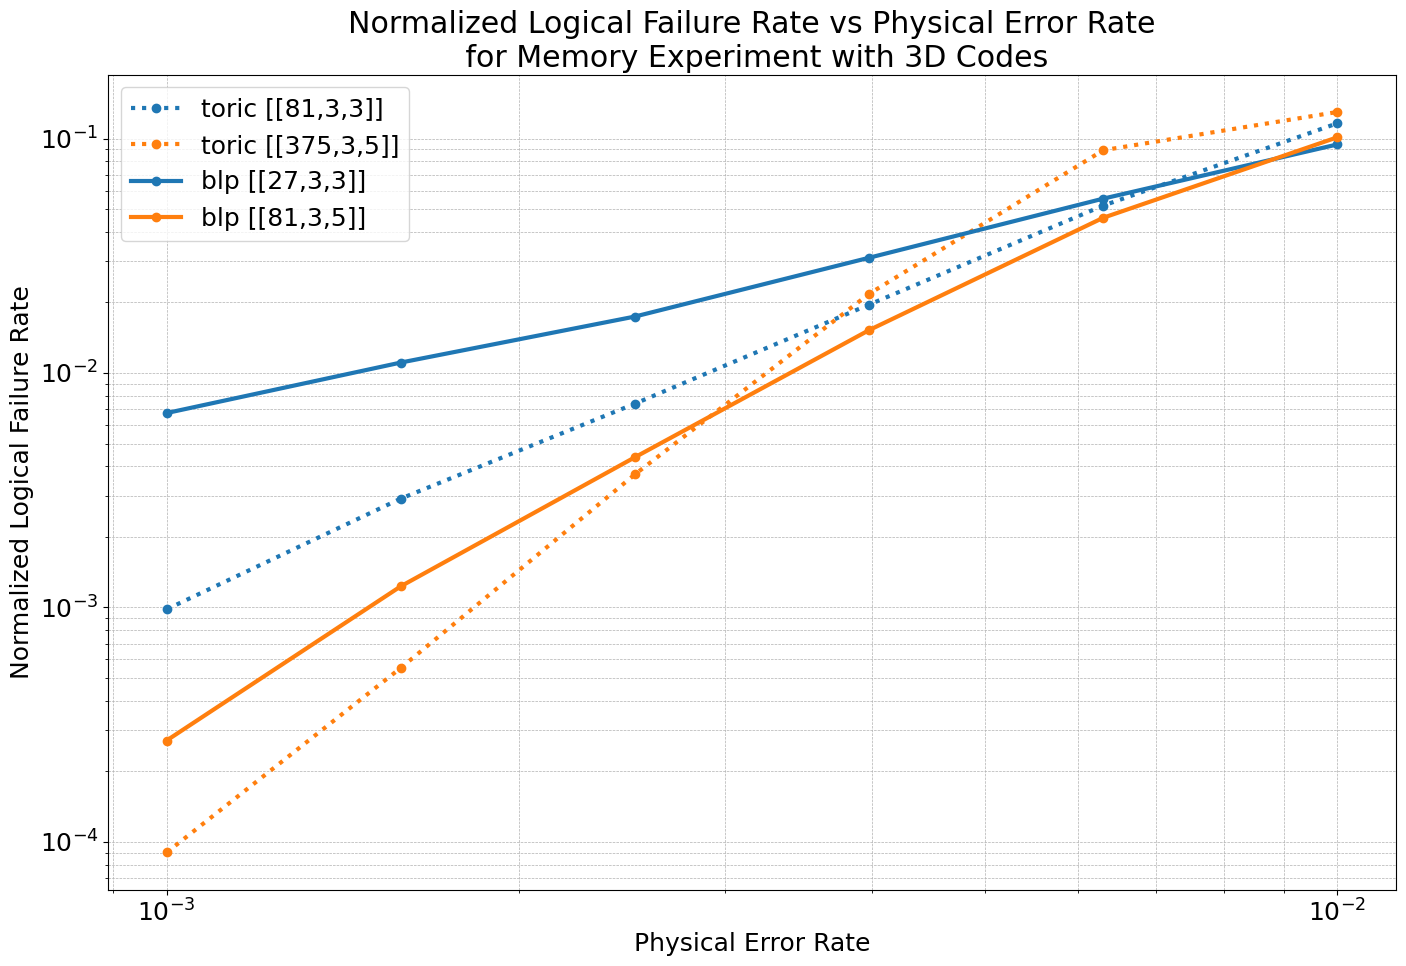

In [7]:
import matplotlib.pyplot as plt

printed_code_params = {code_id: f"{code.code_params}".split('-')[1] for code_id, code in codes_3D.items()}

plt.rcParams.update({'font.size': 18})
fig = plt.figure()
fig.set_figwidth(14.4)
fig.set_figheight(10)

plt.plot(physical_error_rates, normalized_LFRs_dict['d3_toric'], marker='o', linestyle=':', color='C0', label=f"toric {printed_code_params['d3_toric']}", linewidth=3)
plt.plot(physical_error_rates, normalized_LFRs_dict['d5_toric'], marker='o', linestyle=':', color='C1', label=f"toric {printed_code_params['d5_toric']}", linewidth=3)
plt.plot(physical_error_rates, normalized_LFRs_dict['d3_blp'], marker='o', linestyle='-', color='C0', label=f"blp {printed_code_params['d3_blp']}", linewidth=3)
plt.plot(physical_error_rates, normalized_LFRs_dict['d5_blp'], marker='o', linestyle='-', color='C1', label=f"blp {printed_code_params['d5_blp']}", linewidth=3)
# plt.plot(physical_error_rates, normalized_LFRs_dict['d3_pentagon'], marker='o', linestyle='--', color='C0', label=f"pentagon {printed_code_params['d3_pentagon']}", linewidth=3)

plt.xscale('log')
plt.yscale('log')
# plt.ylim(10e-6, 2*10e-2)

# Labels and title
plt.xlabel('Physical Error Rate')
plt.ylabel('Normalized Logical Failure Rate')
plt.title('Normalized Logical Failure Rate vs Physical Error Rate\n for Memory Experiment with 3D Codes')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

plt.tight_layout()
plt.show()